In [1]:
%load_ext autoreload
%autoreload 2

# Import Modules

In [2]:
import Labber
import numpy as np
import os
import matplotlib.pyplot as plt
from fitTools.Resonator import Resonator
import logging

C:\Users\LFL\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


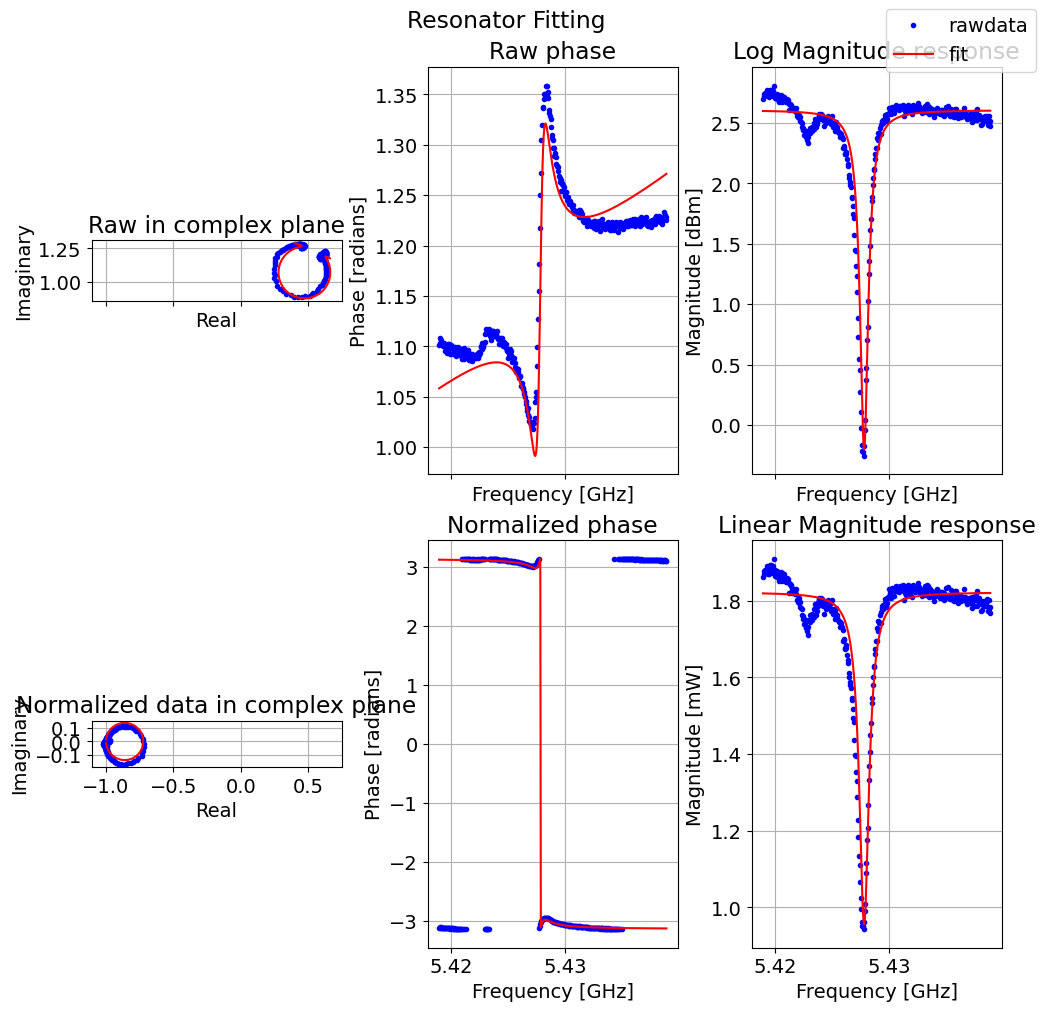


Fit at V dBm
Frequency: 5.4278 GHz
Total Q: 5241
Internal Q: 6080
Coupling Q: 37971
FWHM: 1.03572 MHz
Kappa: 6.50761 MHz
Single Photon Power: -133.7 dBm
Ringdown Time: 0.213 us
Impedance Mismatch 12.320 degrees
Electrical Delay: -1.463651 ns
SNR: 201.9

Q_ext = [37970.9792937097], Q_int = [6079.735692289246], Q_tot = [5240.63044507943]


<Figure size 900x600 with 0 Axes>

: 

In [8]:
res_idx = 1
directory = r'G:\Shared drives\Labber\Data\2024\09\Data_0923\darpa-v3p3-resonator-spectroscopy-6p48Ghz.hdf5'
# directory = r'G:\Shared drives\CavityCooling\DARPA\Data\LabberData\2024\04\Data_0430\highQ-resonators_res1_6p845GHz_power-sweep_-100dB_Fixed.hdf5'
chip_name = 'highQ-resonators-round3-chipA-'
res = f'res{res_idx}'
suffix = '-40db-atten.hdf5'
fpath = os.path.join(directory,chip_name+res+suffix)
# fpath = r'G:\Shared drives\CavityCooling\DARPA\Data\LabberData\2024\04\Data_0430\highQ-resonators_res1_6p845GHz_power-sweep_-100dB_Fixed.hdf5'
#G:\Shared drives\CavityCooling\DARPA\Data\LabberData\2024\04\Data_0430\highQ-resonators_res1_6p845GHz_power-sweep_-100dB_Fixed.hdf5
# fpath = r'G:\Shared drives\Labber\Data\2024\04\Data_0426\highQ-resonators-round3-chipA-res1-40db-atten.hdf5'
# fpath = r'G:\Shared drives\Labber\Data\2024\08\Data_0806\highQ-resonators-round4-chip-v3-res4-powersweep.hdf5'
fpath = r'G:\Shared drives\Labber\Data\2024\09\Data_0930\darpa-LL-06-resonator-spectroscopy-5p41Ghz.hdf5'
fit_resonator(fpath,res_type="r")
# convert_data_to_csv(fpath, save_header=False)

In [8]:
!pip install numpy==1.19 --user

  Using cached numpy-1.19.0-cp38-cp38-win_amd64.whl.metadata (2.0 kB)
Using cached numpy-1.19.0-cp38-cp38-win_amd64.whl (13.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.10.1 requires numpy<1.27.0,>=1.19.5, but you have numpy 1.19.0 which is incompatible.


# Power Sweep

In [ ]:
res_idx = 5
res = f'res{res_idx}'
suffix = '-power-sweep.hdf5'
fpath = os.path.join(directory,chip_name+res+suffix)
fit_resonator(fpath,res_type="n")

# Functions

## Fit single resonator

In [3]:
def load_datafile(filepath):
    '''Load Labber data file and create a log file for logging information'''
    path,fname = os.path.split(fpath)
    path += r'\\'
    figpath = 'figures\\'+fname[:-4]+'\\'
    if not os.path.exists(path+'figures\\'):
        os.mkdir(path+'figures\\')
    if not os.path.exists(path+figpath):
        os.mkdir(path+figpath)
    lf = Labber.LogFile(path + fname)

    logFileName = path + f"profile_info_{fname[:-4]}log"
    logging.basicConfig(level=logging.INFO, format='%(message)s')
    logger = logging.getLogger()
    logger.addHandler(logging.FileHandler(logFileName, 'a'))
    print = logger.info

    return lf

In [4]:
def fit_resonator(fpath:str,res_type:str = "n", attenuation=40, fcrop=None, delay=0):
    plt.rcParams.update({'font.size':14})

    # fpath = input("Path to .hdf5 file: ").replace('"','')
    # res_type = input("What is the resonator type? [\"n\" for notch, \"r\" for reflection, and \"t\" for transmission]: \n")
    if res_type not in ["r","t","n"]:
        res_type = "n"
        print("Notch type resonator used by default")
    
    lf = load_datafile(fpath)

    nEntries = lf.getNumberOfEntries()
    pow_offset = attenuation # Attens after VNA 
    power = lf.getStepChannels()[0]["name"]

   # a = 0
   # b = 0

    fits = {'f':[],'Q':[],'Qint':[],'Qext':[]}
    for n in range(nEntries):
        (xdata,ydata) = lf.getTraceXY(entry = n)
        res = Resonator(res_type, xdata,ydata)
        
        # try:
        if fcrop is not None:
            res.autofit(fcrop=fcrop, electric_delay=delay)
        else:
            res.autofit()
        # except:
        # fstart = input("Enter start frequency for fit in GHz: ")
        # fstop = input("Enter stop frequency for fit in GHz: ")
        # res.autofit(fcrop=(fstart,fstop))
        fits['f'].append(res.f0*1e-9)
        fits['Q'].append(res.Q)
        fits['Qint'].append(res.Qi)
        fits['Qext'].append(res.Qc)

        if res.fit_found:
            print(20*"=")
            # res.show(savefile = path+figpath+fname[:-4]+'resonance_{}-dBm.png'.format(power[n]))
            res.show()
            print('\nFit at {} dBm'.format(power[n]))
            print(res)
            print(20*"="+"\n")


    fig = plt.figure(figsize=[9,6],constrained_layout=True)
    
    if n > 1:
        fig = plt.figure(figsize=[9,6],constrained_layout=True)
        plt.plot(power,fits['f'],'r.')
        plt.title('Frequency vs power')
        plt.xlabel('Input Power [dBm]')
        #plt.xlabel('LO attenuation [dB]')
        plt.ylabel('Frequency from fit [GHz]')
        plt.savefig(path+figpath+fname[:-4]+'_f0-vs-P.png')
        plt.show()

        fig = plt.figure(figsize=[9,6],constrained_layout=True)
        plt.scatter(power,fits['Q'],s=20,c='r',label='Total Q')
        plt.scatter(power,fits['Qint'],s=20,c='b',label='Internal Q')
        plt.scatter(power,fits['Qext'],s=20,c='g',label='external Q')
        plt.yscale("log")
        plt.title('Q vs power')
        plt.xlabel('Input Power [dBm]')
        #plt.xlabel('LO attenuation [dB]')
        plt.ylabel('Quality factor')
        plt.legend()
        plt.savefig(path+figpath+fname[:-4]+'_Q-vs-P.png')
        plt.show()

        plt.scatter(power,np.array(fits['Q'])/np.array(fits['Qint']))
        plt.ylabel("Q/Q_i")
        plt.xlabel('Input Power [dBm]')
        plt.savefig(path+figpath+fname[:-4]+'_Q_over_Qi.png')
        plt.show()
    print(f"Q_ext = {fits['Qext']}, Q_int = {fits['Qint']}, Q_tot = {fits['Q']}")
    # print(f"\n\nLog File: {logFileName}")
    # print(f"\nPlots Directory: {path + figpath}")

In [5]:
import pandas as pd

def convert_data_to_csv(filepath, save_header=False):
    lf = load_datafile(filepath)
    
    (freqs, zdata) = lf.getTraceXY(entry = 0)
    phases =  np.unwrap(np.angle(zdata))
    
    # Create a DataFrame with xdata and ydata
    df = pd.DataFrame({'freqs': freqs, 'amps': abs(zdata), 'phases': 180/np.pi*phases})
    
    # Get the file name without extension
    file_name = os.path.splitext(filepath)[0]
    
    # Strip the .hdf5 ending from the file_name
    file_name = file_name.rstrip('.hdf5')
    
    # Save the DataFrame to a CSV file
    csv_file = file_name + '.csv'
    plt.plot(freqs,np.abs(zdata))
    df.to_csv(csv_file, header=save_header, index=False)
    
    return csv_file
    


ModuleNotFoundError: No module named 'pandas'